In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "subclass_loops.09.19.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,STR_RSPO2_GABA,6.548642e-09,1.178553e-09,1.376115e-08,Mullins.NatGenet.2021.Bipolar_Disorder_,7.861345
1,STR_D2_MSN,6.631100e-09,1.226376e-09,3.203227e-08,Mullins.NatGenet.2021.Bipolar_Disorder_,7.494412
2,ACx_MEIS2_GABA,1.221990e-08,2.374966e-09,1.335519e-07,Mullins.NatGenet.2021.Bipolar_Disorder_,6.874350
3,STR_D1_MSN,6.044823e-09,1.219395e-09,3.575264e-07,Mullins.NatGenet.2021.Bipolar_Disorder_,6.446692
4,Glut,6.036109e-09,1.231740e-09,4.780299e-07,Mullins.NatGenet.2021.Bipolar_Disorder_,6.320545


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

960     1.820458e-07
2816    2.095111e-07
1952    5.088482e-07
2817    5.088482e-07
961     5.088482e-07
            ...     
1718    9.994333e-01
1719    9.994333e-01
1720    9.994333e-01
1722    9.994333e-01
575     9.994333e-01
Name: FDR_BH_corrected, Length: 608, dtype: float64


In [10]:
print(adj_pval.sort_values())

960     1.820458e-07
2816    2.095111e-07
1952    5.088482e-07
961     5.752116e-07
2817    7.289045e-07
            ...     
1723    1.006128e+00
1183    1.006579e+00
574     1.006640e+00
1722    1.007685e+00
575     1.008085e+00
Name: adj_pval, Length: 608, dtype: float64


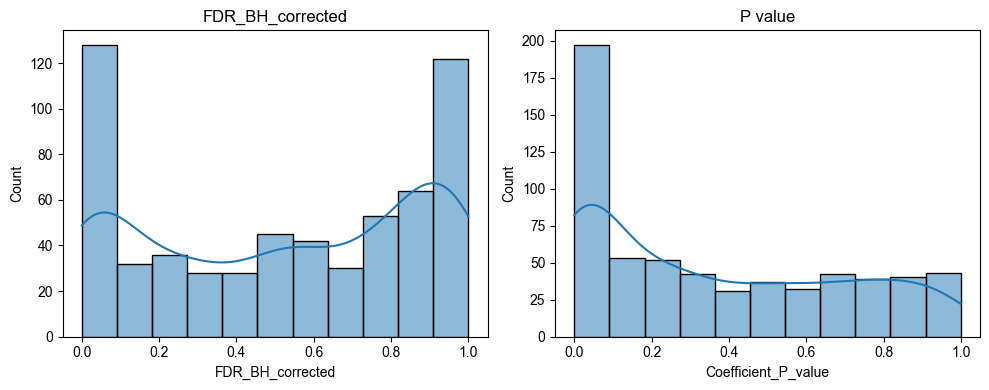

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,1.956307,0.049203,0.080684,0.979728,0.174564,0.837458,0.004704,0.638352,4.195080,6.874350,0.120952,5.814171,0.506829,6.834101,0.053297,6.288949,0.544234,1.822870,0.507989
Astrocyte,0.049720,0.026312,0.064817,0.135307,0.291213,0.532037,0.388838,0.381211,0.870139,2.120233,1.380626,0.809575,0.325606,1.651564,0.235669,0.966076,0.507526,0.522268,0.175602
CN_Cholinergic_GABA,0.401354,0.495111,0.025386,1.791332,0.348236,0.225287,0.000246,0.230316,0.426941,0.063930,0.319738,1.083859,0.169491,0.504678,1.257741,3.078745,0.546426,1.028414,0.166602
CN_GABA-Glut,0.306933,0.298366,0.638742,0.497549,0.569050,0.491982,0.015151,1.192107,1.131544,2.006928,1.251238,1.644067,0.109600,2.337898,1.002737,1.204301,0.751307,0.795473,0.119103
CN_LAMP5-CXCL14_GABA,0.568753,0.808553,0.129805,1.106303,0.195641,1.034709,0.010051,2.309561,2.827411,5.741771,0.387051,2.726044,0.678302,5.406537,0.441392,5.274636,0.653884,2.329606,0.262691


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.064034,0.970498,0.950877,0.300809,0.884264,0.381925,0.999433,0.508383,0.000902,0.000005,0.924108,0.000036,0.583456,0.000005,0.970498,0.000014,0.561108,0.077473,0.583456
Astrocyte,0.970498,0.990065,0.964660,0.908657,0.775232,0.566965,0.697602,0.700140,0.364403,0.049566,0.162238,0.398010,0.752028,0.102086,0.829078,0.307195,0.583456,0.570802,0.884075
CN_Cholinergic_GABA,0.681626,0.591013,0.990465,0.080577,0.729116,0.833925,0.999433,0.832551,0.659392,0.964660,0.758288,0.263810,0.886942,0.583456,0.204795,0.009221,0.561108,0.283579,0.887226
CN_GABA-Glut,0.771487,0.775232,0.508383,0.589496,0.545236,0.593481,0.999433,0.221965,0.246768,0.058664,0.205193,0.102975,0.936023,0.035580,0.293292,0.220838,0.431178,0.405714,0.924601
CN_LAMP5-CXCL14_GABA,0.545236,0.398010,0.916501,0.255910,0.866873,0.283484,0.999433,0.036352,0.013918,0.000041,0.697602,0.017052,0.487851,0.000077,0.641530,0.000101,0.503367,0.035580,0.801220


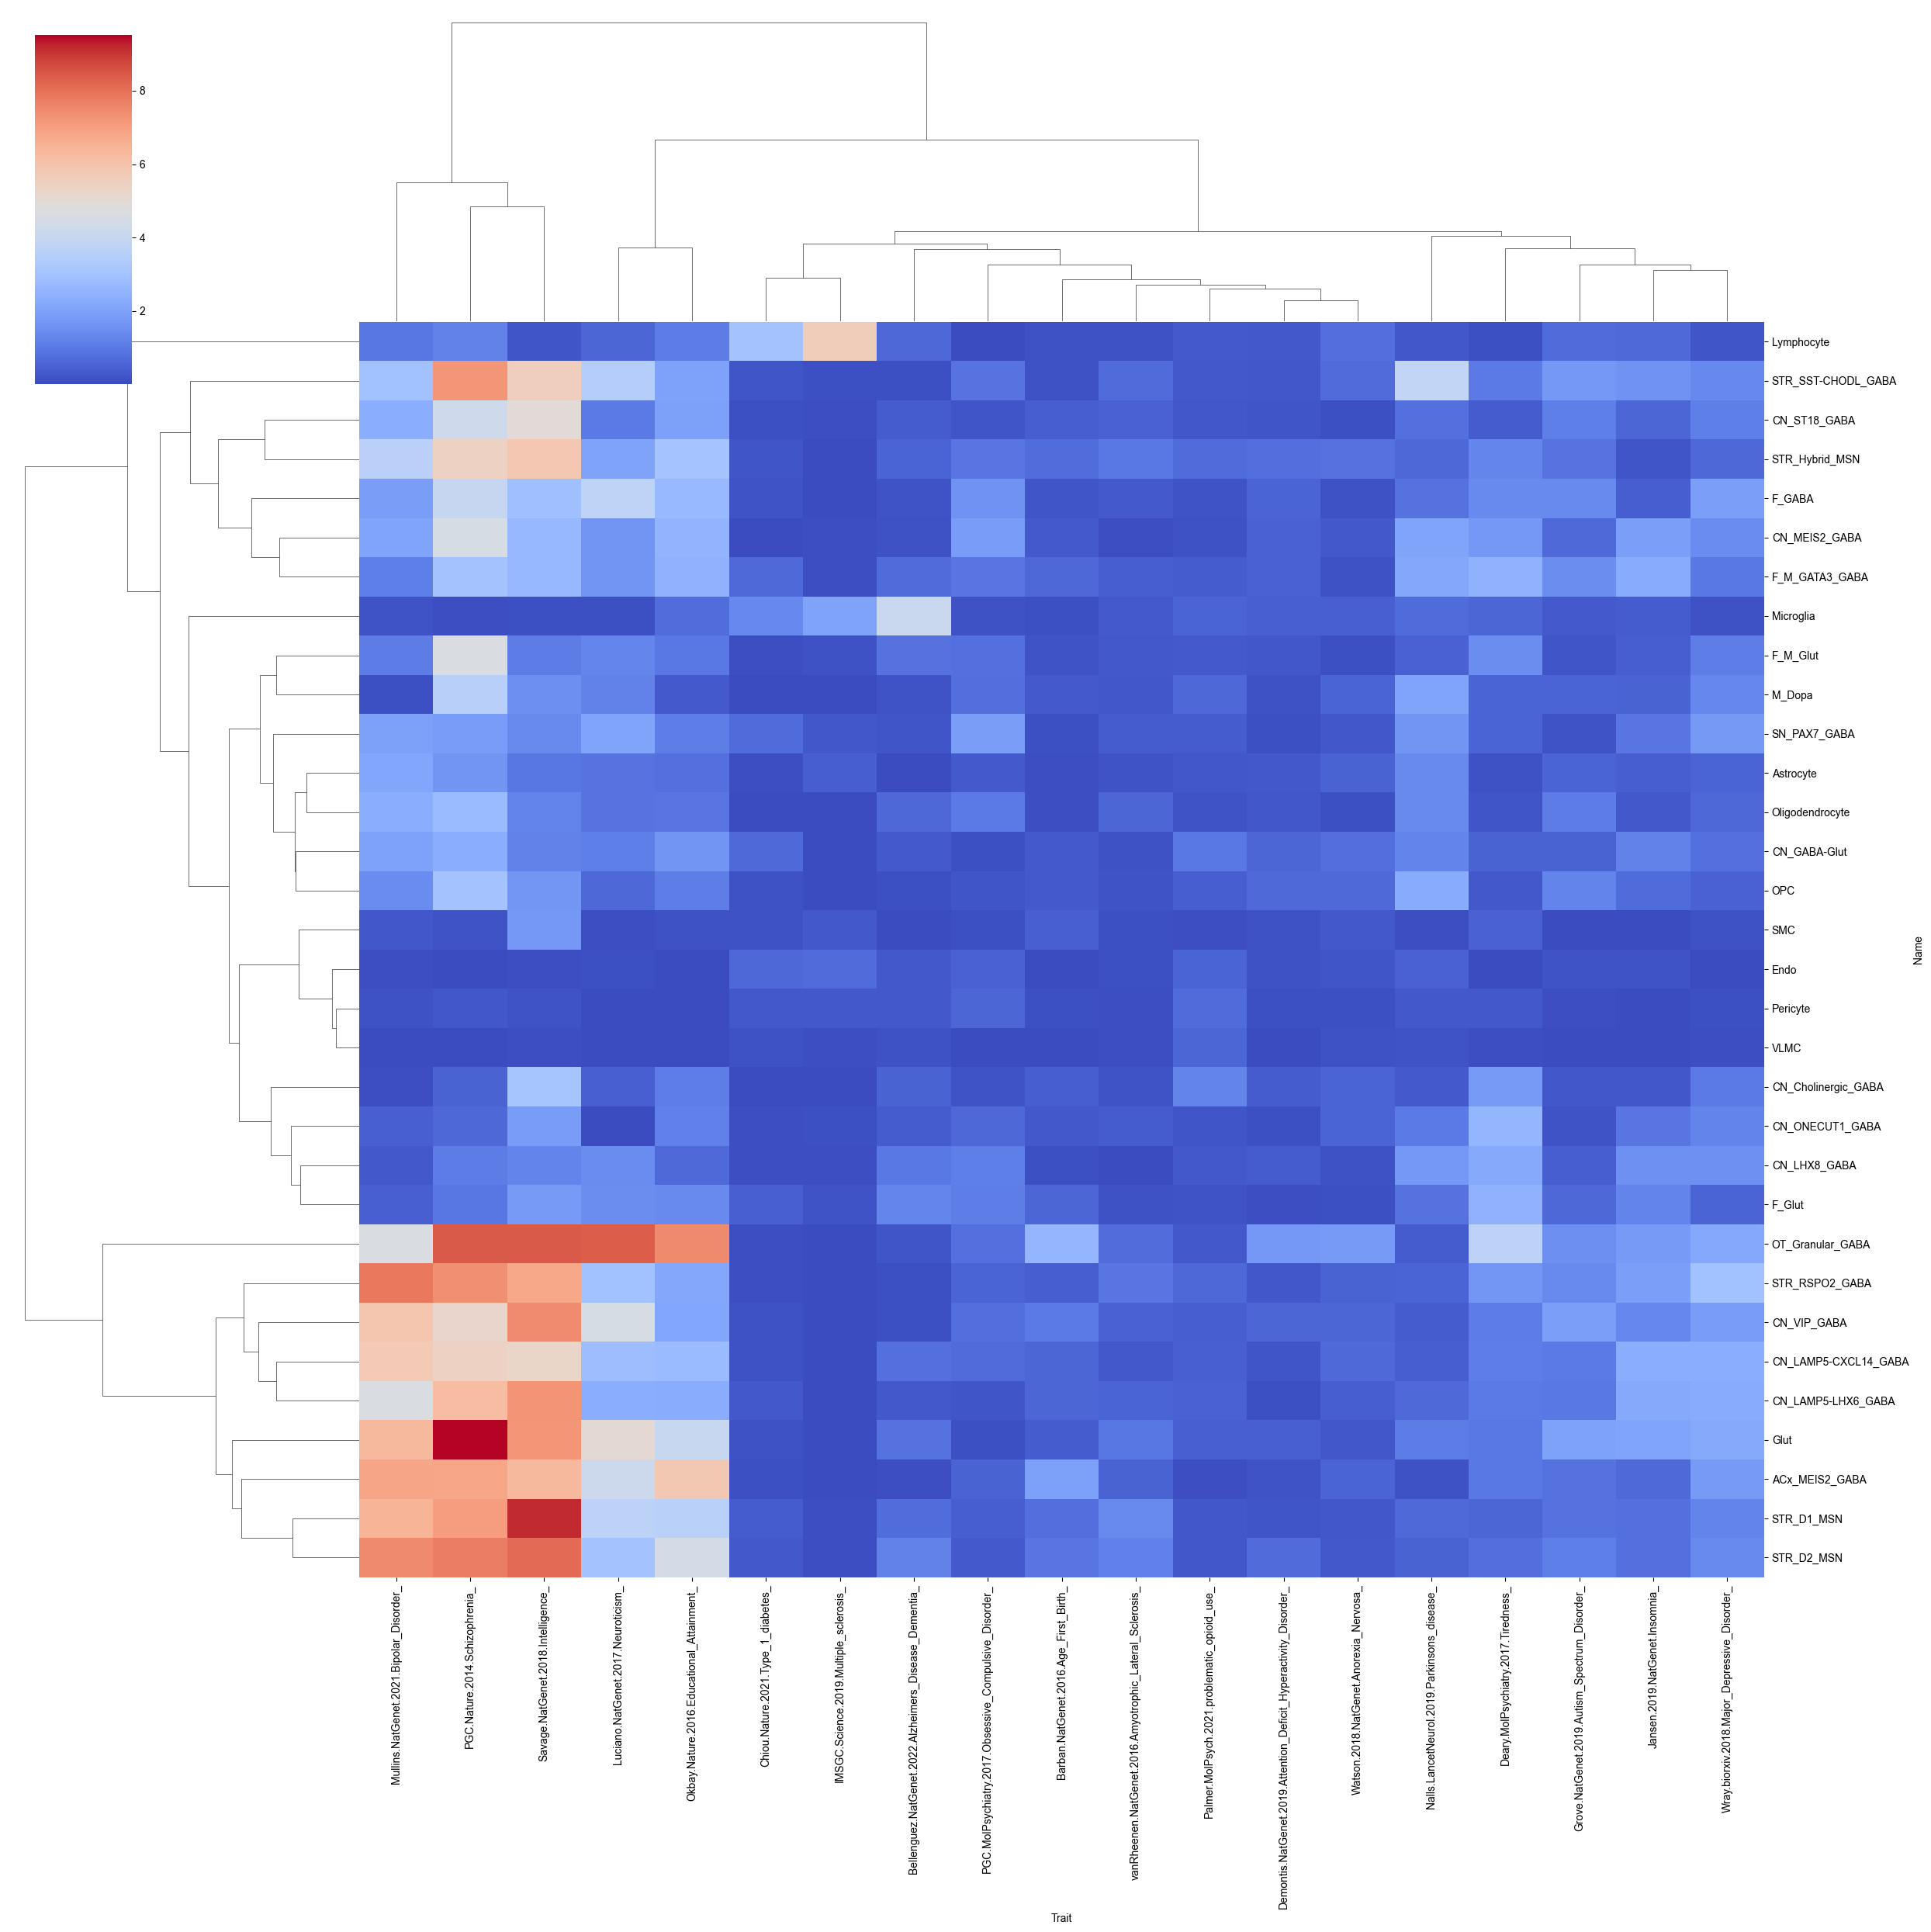

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
# g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Bipolar Disorder', 'Schizophrenia', 'Intelligence', 'Neuroticism',
       'Educational Attainment', 'Type 1 Diabetes', 'Multiple Sclerosis',
       'Alzheimers Disease and Dementia', 'Age at First Birth',
       'Parkinson's Disease', 'Tiredness', 'Insomnia',
       'Major Depressive Disorder'],
      dtype='object', name='Trait')

In [19]:
# stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

# # Plot heatmap with annotations
# plt.figure(figsize=(25, 15))
# sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
# plt.title("-log10(pval) with FDR corrected p value stars")
# plt.tight_layout()
# plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
# plt.show()



In [20]:
import os
metadata = pd.read_csv(os.path.expanduser("~/Projects/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols.head()

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron


In [21]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

In [22]:
vmax=modified_df.loc[:,cols_to_keep].max().max()
print(vmax)

9.523722991583435


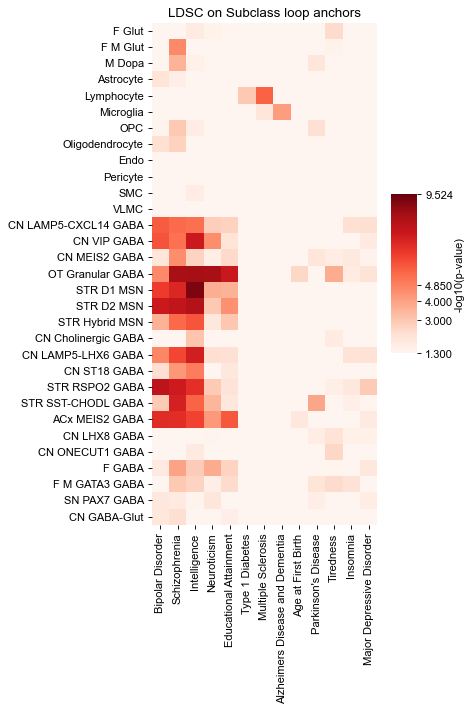

In [24]:
# Plot heatmap with annotations
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
fig, ax = plt.subplots(figsize=(6, 9))
ax=sns.heatmap(modified_df.loc[row_order,cols_to_keep], #annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='Reds',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),vmin=1.3,vmax=vmax,#cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title("LDSC on Subclass loop anchors")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([1.3,3,4,4.85,vmax])
plt.tight_layout()
# plt.savefig(f'{run_id}_filtered_FDR.pdf')
plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/Subclass_loops.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()